In [5]:
import numpy as np
import tensorflow as tf
import helpful_functions as hf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import time

# ---only for cluster--- #
import tensorflow as tf

phys_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(phys_devices[0], True)
except IndexError:
    pass

In [6]:
# -----2 Inputs: 64x64 pixel, latent vector: 10x10x16 ----- #
#encoder
encoder_inputs = keras.Input(shape=(64, 64, 1), name="img_input")
x = layers.Conv2D(8, 3, activation="relu")(encoder_inputs)
x = layers.Conv2D(16, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(16, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(16, 3, activation="relu")(block_2_output)
block_3_output = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(16, 3, activation="relu", padding="same")(block_3_output)
x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
block_4_output = layers.add([x, block_3_output])

x  = layers.Conv2D(16, 3, activation="relu")(block_4_output)
encoder_outputs= layers.Conv2D(16, 3, activation="relu")(x)

encoder = keras.Model(encoder_inputs, encoder_outputs, name="encoder")
#encoder.summary()

#decoder
decoder_inputs = keras.Input(shape=(10, 10, 16), name="decoder_input")
x = layers.Conv2DTranspose(16, 3, activation="relu")(decoder_inputs)
block_5_output = layers.Conv2DTranspose(16, 3, activation="relu")(x)

x = layers.Conv2DTranspose(16, 3, activation="relu", padding="same")(block_5_output)
x = layers.Conv2DTranspose(16, 3, activation="relu", padding="same")(x)
block_6_output = layers.add([x, block_5_output])

x = layers.UpSampling2D(2)(block_6_output)
block_7_output = layers.Conv2DTranspose(16, 3, activation="relu")(x)

x = layers.Conv2DTranspose(16, 3, activation="relu", padding="same")(block_7_output)
x = layers.Conv2DTranspose(16, 3, activation="relu", padding="same")(x)
block_8_output = layers.add([x, block_7_output])

x = layers.UpSampling2D(2)(block_8_output)
x = layers.Conv2DTranspose(8, 3, activation="relu")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="relu")(x)

decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
#decoder.summary()

# bild autoencoder
autoencoder_input1 = keras.Input(shape=(64, 64, 1), name="input_img1")
autoencoder_input2 = keras.Input(shape=(64, 64, 1), name="input_img2")

encoded_img1 = encoder(autoencoder_input1)
encoded_img2 = encoder(autoencoder_input2)


encoded_img3 = layers.add([encoded_img1,encoded_img2])
decoded_img1 = decoder(encoded_img1)
decoded_img2 = decoder(encoded_img2)
decoded_img3 = decoder(encoded_img3)

autoencoder = keras.Model(inputs=[autoencoder_input1,autoencoder_input2], outputs=[decoded_img1,decoded_img2,decoded_img3], name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img1 (InputLayer)        [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 input_img2 (InputLayer)        [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           (None, 10, 10, 16)   17488       ['input_img1[0][0]',             
                                                                  'input_img2[0][0]']             
                                                                                                  
 add_9 (Add)                    (None, 10, 10, 16)   0           ['encoder[0][0]',      

keras.utils.plot_model(encoder, "output/struktur_autoencoder/64_encoder.png", show_shapes=True, dpi=150)
keras.utils.plot_model(decoder, "output/struktur_autoencoder/64_decoder.png", show_shapes=True, dpi=150)

In [7]:
# load data_set
#data_set = hf.load_dataset_npz('data_set/2Inputs_64pix_3-8_ratio05_1.npz')
data_set = hf.load_dataset_npz('data_set/2Inputs_64pix_3-8_ratio05.npz')
#data_set = hf.load_dataset_npz('data_set/2Inputs_64pix_3-8_ratio07.npz')
data_set = data_set.astype('float32')
x_train = data_set[:8000, :2]
y_train = data_set[:8000]
x_test = data_set[8000:, :2]
y_test = data_set[8000:]
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(8000, 2, 64, 64, 1)
(8000, 3, 64, 64, 1)
(2000, 2, 64, 64, 1)
(2000, 3, 64, 64, 1)


In [8]:
# Training
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
autoencoder.compile(optimizer=optimizer, loss=losses.MeanSquaredError())

monitor = EarlyStopping(monitor='loss', min_delta=1e-5, patience=5,
                        verbose=1, mode='auto', restore_best_weights=True)
tic = time.perf_counter()
history = autoencoder.fit([x_train[:,0],x_train[:,1]], [y_train[:,0],y_train[:,1],y_train[:,2]], epochs=40,
                          validation_data=((x_test[:,0],x_test[:,1]), (y_test[:, 0],y_test[:, 1],y_test[:, 2])),
                          shuffle=True, batch_size=80)
toc = time.perf_counter()
print(f"Training in {toc - tic:0.4f} seconds")

Epoch 1/40


2023-05-21 18:49:55.968054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 0.0264 - decoder_loss: 0.0065 - decoder_1_loss: 0.0065 - decoder_2_loss: 0.0134

2023-05-21 18:50:04.561593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 11s 91ms/step - loss: 0.0264 - decoder_loss: 0.0065 - decoder_1_loss: 0.0065 - decoder_2_loss: 0.0134 - val_loss: 0.0067 - val_decoder_loss: 0.0016 - val_decoder_1_loss: 0.0015 - val_decoder_2_loss: 0.0036
Epoch 2/40
100/100 [==============================] - 8s 77ms/step - loss: 0.0049 - decoder_loss: 0.0011 - decoder_1_loss: 0.0011 - decoder_2_loss: 0.0027 - val_loss: 0.0035 - val_decoder_loss: 7.9017e-04 - val_decoder_1_loss: 7.6166e-04 - val_decoder_2_loss: 0.0020
Epoch 3/40
100/100 [==============================] - 8s 77ms/step - loss: 0.0034 - decoder_loss: 7.5477e-04 - decoder_1_loss: 7.4897e-04 - decoder_2_loss: 0.0019 - val_loss: 0.0025 - val_decoder_loss: 5.4222e-04 - val_decoder_1_loss: 5.2364e-04 - val_decoder_2_loss: 0.0015
Epoch 4/40
100/100 [==============================] - 8s 77ms/step - loss: 0.0024 - decoder_loss: 4.9890e-04 - decoder_1_loss: 4.9599e-04 - decoder_2_loss: 0.0014 - val_loss: 0.0021 - val_decoder_loss: 4.3688e

In [9]:
# save the trained model
autoencoder.save('saved_model/autoencoder_80batch_lr005_40epochs2')
encoder.save('saved_model/encoder_(10x10x16)_64pix_bs80_ratio05_1302')
decoder.save('saved_model/decoder_(10x10x16)_64pix_bs80_ratio05_1302')

INFO:tensorflow:Assets written to: saved_model/autoencoder_80batch_lr005_40epochs2/assets


INFO:tensorflow:Assets written to: saved_model/autoencoder_80batch_lr005_40epochs2/assets


In [11]:
# make predictions
predictions = autoencoder.predict([x_test[:,0],x_test[:,1]])
np.shape(predictions)

2023-05-21 19:09:20.710854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 2s 24ms/step


(3, 2000, 64, 64, 1)

In [12]:
# calculate the mse and ssim
mse = tf.keras.losses.MeanSquaredError()
#mse(y_test[:,3], predictions[3]).numpy()
print(f"mse is: {mse(y_test[:,2], predictions[2]).numpy()}")
ssim = tf.image.ssim(y_test[:,2], predictions[2], max_val=1.0)
ssim_mean = np.mean(ssim)
print(f"ssim is for sample {808}: {ssim[807].numpy()}")
print(f"mean of ssim is: {ssim_mean}")

mse is: 0.0003653030435089022
ssim is for sample 808: 0.9772405028343201
mean of ssim is: 0.9950870871543884


In [13]:
# save the training loss and ssim
history_df = pd.DataFrame(history.history)
history_ssim = pd.DataFrame(ssim)
with open('for_ausarbeitung/Aus/autoencoder_80batch_lr005_40epochs2.csv', 'wb') as file:
    history_df.to_csv(file)
with open('for_ausarbeitung/Aus/autoencoder_80batch_lr005_40epochs-ssim2.csv', 'wb') as file:
    history_ssim.to_csv(file)

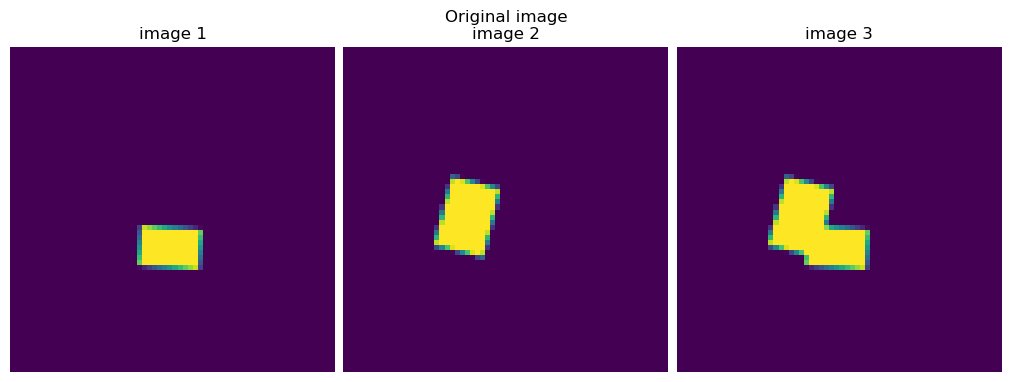

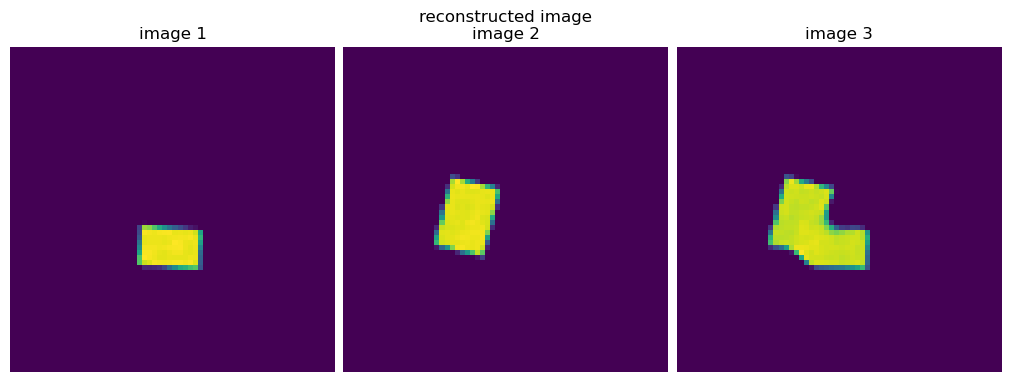

In [11]:
# visualization of the predictions
hf.show_image(sample_num=280, img_data1=data_set,img_data2=predictions)
#for i in range(2):
    #hf.show_image(sample_num=i+1, img_data1=data_set,img_data2=predictions)

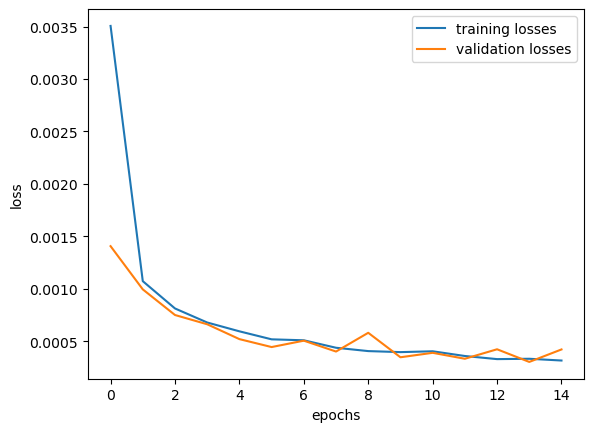

In [9]:
# Visualization of the training loss
fig, ax = plt.subplots()

epochs = range(len(history_df))
loss = history_df['decoder_2_loss']
val_loss = history_df['val_decoder_2_loss']
ax.set_xlabel('epochs')  # Add an x-label to the axes.
ax.set_ylabel('loss')  # Add a y-label to the axes.

ax.plot(epochs, loss, label='training losses')
ax.plot(epochs, val_loss, label='validation losses')
ax.legend()
#ax.text(30, 0.0005, f'(30,{loss[29]})', color='b')
#ax.annotate('(30, {:.2e})'.format(loss[29]), xy=(30, loss[29]), xytext=(35, 0.0006),
#            arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

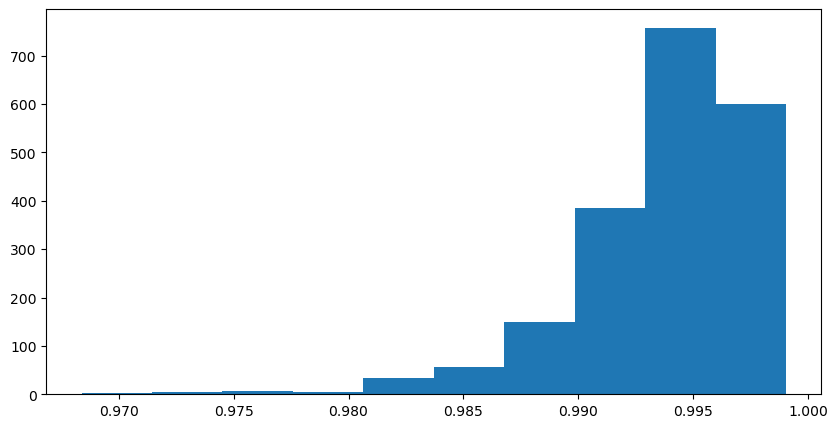

In [10]:
# Visualization of the ssim distribution

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(history_ssim)
plt.show()